# 0. Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Load Data
- 호연이 형 전처리 데이터 + 정상 데이터 3개 합쳐둔 csv

In [10]:
data = pd.read_csv('/content/drive/MyDrive/KAMP/data/rate_zero_more.csv', header=None)

In [11]:
print(data.shape)
data.head()

(55336, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,27.8645,99.6709,100.0340,69.6122,48.3653,48.9108,0.450569,859.518,859.896,859.787,860.029,278.475,284.534,329.164
1,25.3182,99.6709,99.9727,69.6122,48.3572,48.9786,0.450856,859.767,859.896,859.787,860.091,278.537,284.595,329.225
2,25.3030,99.6709,100.0340,69.6736,48.4052,49.0409,0.451001,859.767,859.896,859.787,860.091,278.475,284.534,329.225
3,25.2896,99.6709,100.0340,69.6736,46.8729,49.0980,0.451201,859.767,859.958,859.787,860.091,278.475,284.534,329.225
4,25.2778,99.6709,100.0340,69.6122,46.8696,49.0629,0.451377,859.767,859.960,859.791,860.097,278.425,284.486,329.174


# 2. Pre-Process Data
- 최대한 같은 배정번호끼리 묶고 싶어서 train, test split 할 때, shuffle = false로 진행
  - 어차피 완전히 새로운 데이터가 들어온다고 했을 때도, shuffle 돼서 들어오지 않기 때문에 괜찮다고 생각함.

In [12]:
# 데이터 정규화
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# 데이터 분할
train_data, test_data = train_test_split(data_normalized, test_size=0.2, random_state=42, shuffle=False)

# 3. Model

## 3.1 Data Loader
- 위와 동일한 이유로 batch split을 shuffle = false로 진행

In [13]:
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## 3.2 Create Model

In [14]:
class LSTM_AE(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_AE, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        out, _ = self.encoder(x)
        out, _ = self.decoder(out)
        return out

In [15]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, loss, model, model_path):
        score = -loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, model_path)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, model_path)
            self.counter = 0

    def save_checkpoint(self, model, model_path):
        torch.save(model.state_dict(), model_path)

In [16]:
# 모델, 옵티마이저, 손실 함수 정의
model = LSTM_AE(input_size=14, hidden_size=10, num_layers=1)

In [17]:
# 손실함수 MSE, 옵티마이저 Adam, 학습률 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# Early Stopping 초기화
early_stopping = EarlyStopping(patience=10)

## 3.3 Train Model

In [19]:
epochs = 100
loss_history = []

for epoch in range(epochs):
    model.train()
    for i, (x,) in enumerate(train_loader):
        output = model(x)
        loss = criterion(output.squeeze(), x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    early_stopping(loss.item(), model, '/content/drive/MyDrive/KAMP/model/LSTM_AE_best_model.pth')
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch [1/100], Loss: 0.1857
Epoch [2/100], Loss: 0.1757
Epoch [3/100], Loss: 0.1856
Epoch [4/100], Loss: 0.1703
Epoch [5/100], Loss: 0.1138
Epoch [6/100], Loss: 0.0866
Epoch [7/100], Loss: 0.0780
Epoch [8/100], Loss: 0.0686
Epoch [9/100], Loss: 0.0635
Epoch [10/100], Loss: 0.0626
Epoch [11/100], Loss: 0.0588
Epoch [12/100], Loss: 0.0547
Epoch [13/100], Loss: 0.0526
Epoch [14/100], Loss: 0.0488
Epoch [15/100], Loss: 0.0468
Epoch [16/100], Loss: 0.0472
Epoch [17/100], Loss: 0.0476
Epoch [18/100], Loss: 0.0495
Epoch [19/100], Loss: 0.0506
Epoch [20/100], Loss: 0.0507
Epoch [21/100], Loss: 0.0471
Epoch [22/100], Loss: 0.0462
Epoch [23/100], Loss: 0.0486
Epoch [24/100], Loss: 0.0486
Epoch [25/100], Loss: 0.0476
Epoch [26/100], Loss: 0.0479
Epoch [27/100], Loss: 0.0463
Epoch [28/100], Loss: 0.0434
Epoch [29/100], Loss: 0.0409
Epoch [30/100], Loss: 0.0391
Epoch [31/100], Loss: 0.0357
Epoch [32/100], Loss: 0.0347
Epoch [33/100], Loss: 0.0333
Epoch [34/100], Loss: 0.0332
Epoch [35/100], Loss: 0

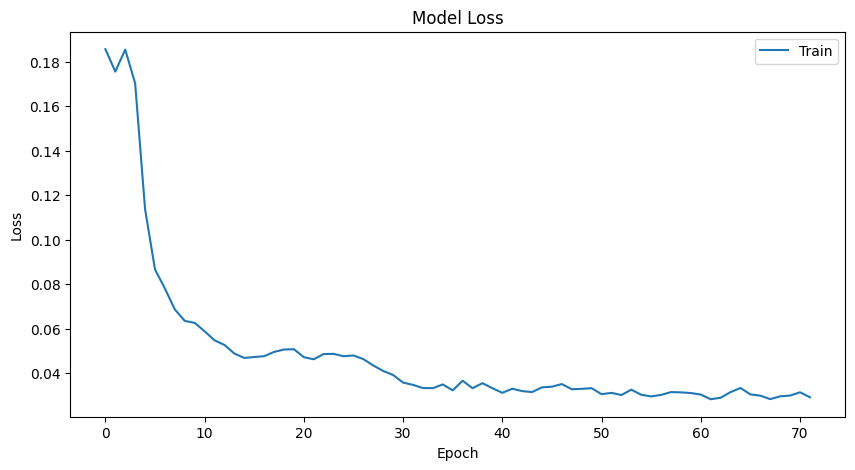

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# 4. Evaluate Model

## 4.1 Test Data
- anomaly score 계산

In [21]:
# 모델 로드 및 평가
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/LSTM_AE_best_model.pth'))
model.eval()

predictions, actuals = [], []
with torch.no_grad():
    for i, (x,) in enumerate(test_loader):
        output = model(x)
        predictions.append(output.numpy())
        actuals.append(x.numpy())

predictions = np.array(predictions).reshape(-1, 14)
actuals = np.array(actuals).reshape(-1, 14)
mse = mean_squared_error(actuals, predictions)
print(f'MSE on test data: {mse:.4f}')

MSE on test data: 0.3546


## 4.2 Anomaly Data
- 배정번호 140920 데이터
    - 정상 60,170 / 불량 120
- anomaly score 계산

In [27]:
# 4.3.1 Load Data
anomaly_data = pd.read_csv('/content/drive/MyDrive/KAMP/data/anomaly_data_140920.csv')

# 4.3.2 Pre-process Data
anomaly_data_scaled = scaler.fit_transform(anomaly_data)
anomaly_data_dataset = TensorDataset(torch.tensor(anomaly_data_scaled, dtype=torch.float32))
anomaly_data_loader = DataLoader(dataset=anomaly_data_dataset, batch_size=1, shuffle=False)

# 4.3.3 Evaluate
model = LSTM_AE(input_size=14, hidden_size=10, num_layers=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/LSTM_AE_best_model.pth'))
model.eval()

anomaly_data_mse = []
with torch.no_grad():
    for i, (x,) in enumerate(anomaly_data_loader):
        output = model(x)
        mse = mean_squared_error(x.numpy(), output.numpy())
        anomaly_data_mse.append(mse)

# Anomaly Score 출력
print(np.mean(anomaly_data_mse))

0.5309687


## 4.3 Almost Normal Data
- 배정번호 142324 데이터
    - 정상 18,127 / 불량 1
- anomaly score 계산
- 정상 데이터를 모두 학습에 활용해서, 학습에 사용되지 않은 데이터 중 가장 정상에 가까운 데이터 사용

In [28]:
# 4.3.1 Load Data
almost_normal_data = pd.read_csv('/content/drive/MyDrive/KAMP/data/almost_normal_data_142324.csv')

# 4.3.2 Pre-process Data
almost_normal_data_scaled = scaler.fit_transform(almost_normal_data)
almost_normal_data_dataset = TensorDataset(torch.tensor(almost_normal_data_scaled, dtype=torch.float32))
almost_normal_data_loader = DataLoader(dataset=almost_normal_data_dataset, batch_size=1, shuffle=False)

# 4.3.3 Evaluate
model = LSTM_AE(input_size=14, hidden_size=10, num_layers=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/KAMP/model/LSTM_AE_best_model.pth'))
model.eval()

almost_normal_data_mse = []
with torch.no_grad():
    for i, (x,) in enumerate(almost_normal_data_loader):
        output = model(x)
        mse = mean_squared_error(x.numpy(), output.numpy())
        almost_normal_data_mse.append(mse)

# Anomaly Score 출력
print(np.mean(almost_normal_data_mse))

0.5330652


# 5. Appendix

- Shuffle=False에 대한 근거
  1. 성능 비교해본 결과, Shffle =True보다 더 낮은 Test MSE를 보였고, Anomaly Data와 더 큰 MSE 차이를 보였다.
    - True일 때, Test : 0.788 / Anomaly : 0.856 -> 0.68 차이
  2. Loss 곡선을 확인해본 결과 다른 데이터들은 삐죽삐죽했는데, 해당 데이터는 이상적인 학습 Loss 곡선을 보임.


- 의문인 점
  - train 데이터로 평가를 진행해봄.
  - 학습 과정에서 0.3x의 Loss 보였는데, 여기선 0.89?
    1. 학습 Loss와 eval은 다른지?
    2. 학습 데이터는 정상 데이터인데 왜 MSE가 이렇게 높은지?

